# Phenotypic phase plane analysis
To analyse the cell factory's response to changes in conditions, most importantly oxygen and glucose, we perform a phenotypic phase plane analysis on the baseline growth and progesterone production.

In [46]:
# Load packages and model
%matplotlib inline
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from cobra.io import read_sbml_model
from cobra.flux_analysis import production_envelope
from cameo import phenotypic_phase_plane
from cameo.visualization.plotting.with_plotly import PlotlyPlotter

model = read_sbml_model('models/iMM904_progesterone.xml') # import model of progesterone producing yeast strain

growth = model.reactions.BIOMASS_SC5_notrace
progesterone = model.reactions.R02216

model

<Model iMM904_progesterone at 0x7f8e2f0a2b80>

Note that the medium contains a surplus of nutrients (denoted with 999999.0), but a restricted source of oxygen and D-glucose:

In [47]:
# Model medium
model.medium # nutrients available in medium

{'EX_fe2_e': 999999.0,
 'EX_glc__D_e': 10.0,
 'EX_h2o_e': 999999.0,
 'EX_h_e': 999999.0,
 'EX_k_e': 999999.0,
 'EX_na1_e': 999999.0,
 'EX_so4_e': 999999.0,
 'EX_nh4_e': 999999.0,
 'EX_o2_e': 2.0,
 'EX_pi_e': 999999.0}

### Biomass vs. progesterone production
The first order of business is to establish the relationship between progesterone production and growth (or biomass production). The phase-plane plot below depicts this relationship:

In [48]:
# Biomass vs. progesterone production
plotter = PlotlyPlotter()
production_envelope_pp = phenotypic_phase_plane(model,
                                             variables=[model.reactions.BIOMASS_SC5_notrace],
                                             objective=model.metabolites.progesterone_c, 
                                             points=10)
production_envelope_pp.plot(plotter, height=400)

Note that fact that for high value of either biomass or progesterone flux, the other is 0. This makes sense, as models with demand for either one depend on glucose and oxygen to create their objective product. There is a nice plateau, though, for the maximum production of progesterone, indicating that simulations/calculations that maximize progesterone can feasibly grow as well.

### Progesterone productivity and yield
Using the `production_envelope` from `cobra.flux_analysis`, we will now simulate and plot the progesterone production for fluxes in the ranges $-10 < \textrm{O}_2 < 0$ and $-20 < \textrm{Glc} < 0$.

In [49]:
# Generate production envelope for progesterone
N_POINTS = 101

with model:
    old_medium = model.medium
    new_medium = model.medium
    new_medium['EX_glc__D_e'] = 20.
    new_medium['EX_o2_e'] = 10.
    model.medium = new_medium
    baseline_max_growth = model.optimize().objective_value
    model.objective = model.reactions.DM_progesterone_c
    baseline_max_production = model.optimize().objective_value
    
    prod_env_prog = production_envelope(model, ["EX_o2_e", "EX_glc__D_e"], objective=progesterone, carbon_sources="EX_glc__D_e", points=N_POINTS)

prod_env_prog.fillna(0, inplace=True)

progesterone_prod = prod_env_prog['flux_maximum']
progesterone_yield = prod_env_prog['carbon_yield_maximum']
o2_input = prod_env_prog['EX_o2_e']
glucose_input = prod_env_prog['EX_glc__D_e']

prod_env_prog[['carbon_source','flux_maximum','carbon_yield_maximum','EX_glc__D_e','EX_o2_e']]

carbon_source  flux_maximum  carbon_yield_maximum  EX_glc__D_e  EX_o2_e
0       EX_glc__D_e      0.762871              0.267005   -20.000000    -10.0
1       EX_glc__D_e      0.759137              0.268374   -19.800588    -10.0
2       EX_glc__D_e      0.755404              0.269771   -19.601176    -10.0
3       EX_glc__D_e      0.751671              0.271197   -19.401765    -10.0
4       EX_glc__D_e      0.747938              0.272652   -19.202353    -10.0
...             ...           ...                   ...          ...      ...
10196   EX_glc__D_e      0.000000              0.000000    -0.856471      0.0
10197   EX_glc__D_e      0.000000              0.000000    -0.657059      0.0
10198   EX_glc__D_e      0.000000              0.000000    -0.457647      0.0
10199   EX_glc__D_e      0.000000              0.000000    -0.258235      0.0
10200   EX_glc__D_e      0.000000              0.000000    -0.058824      0.0

[10201 rows x 5 columns]

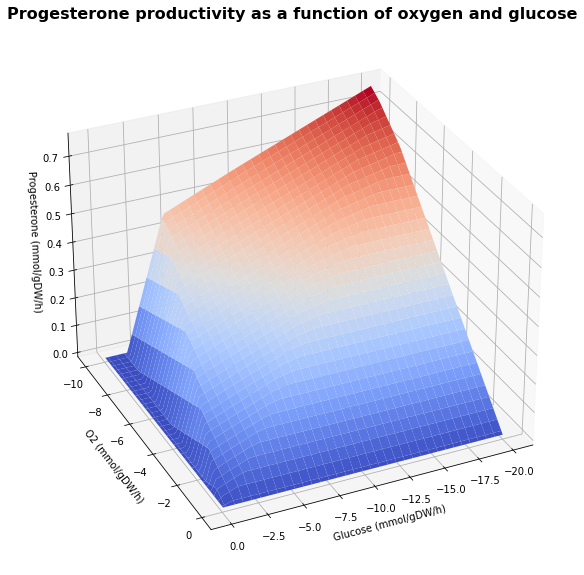

In [50]:
# Progesterone productivity as a function of oxygen and glucose
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection="3d")
X, Y = np.meshgrid(glucose_input[:N_POINTS], o2_input[::N_POINTS])
ax.view_init(30,65)
ax.plot_surface(X,Y, np.nan_to_num(np.array(progesterone_prod).reshape(N_POINTS, N_POINTS)), shade=True, cmap=cm.coolwarm)
ax.set_xlabel("Glucose (mmol/gDW/h)")
ax.set_ylabel("O2 (mmol/gDW/h)")
ax.set_zlabel("Progesterone (mmol/gDW/h)")
ax.set_title("Progesterone productivity as a function of oxygen and glucose", {'fontsize': 16, 'fontweight': 'bold'})
plt.show()

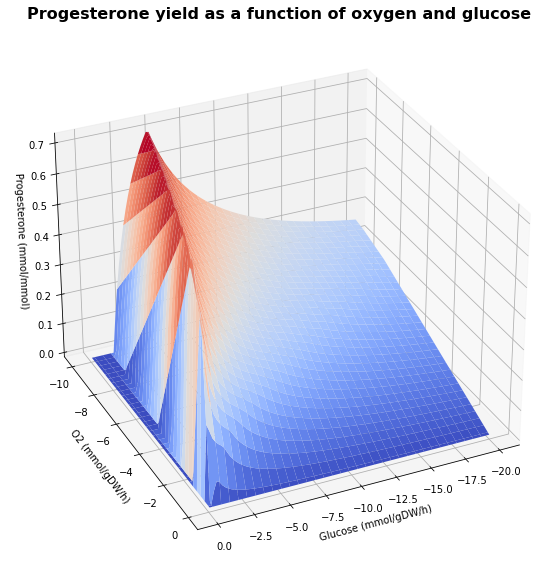

In [51]:
# Progesterone yield as a function of oxygen and glucose
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection="3d")
X, Y = np.meshgrid(glucose_input[:N_POINTS], o2_input[::N_POINTS])
ax.view_init(30,65)
ax.plot_surface(X,Y, np.nan_to_num(np.array(progesterone_yield).reshape(N_POINTS, N_POINTS)), shade=True, cmap=cm.coolwarm)
ax.set_xlabel("Glucose (mmol/gDW/h)")
ax.set_ylabel("O2 (mmol/gDW/h)")
ax.set_zlabel("Progesterone (mmol/mmol)")
ax.set_title("Progesterone yield as a function of oxygen and glucose", {'fontsize': 16, 'fontweight': 'bold'})
plt.show()

The two plots show us interesting behaviours of the cell factory.
Oxygen, which may be explained biologically by oxygen toxicity.

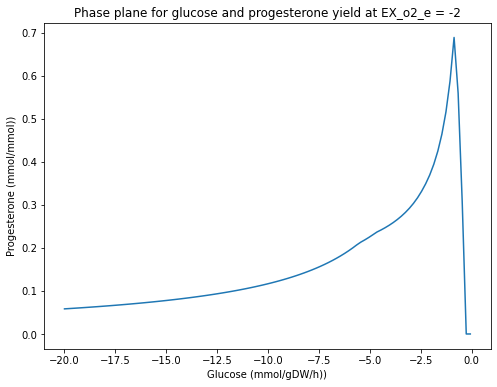

In [82]:
# Phase plane for glucose and progesterone yield at EX_o2_e = -2
set_o2_prod_env = prod_env_prog.loc[prod_env_prog['EX_o2_e'] == -2]

fig = plt.figure(figsize=(8,6))
plt.plot(set_o2_prod_env['EX_glc__D_e'],set_o2_prod_env['carbon_yield_maximum'])
plt.xlabel("Glucose (mmol/gDW/h))")
plt.ylabel("Progesterone (mmol/mmol))")
plt.title("Phase plane for glucose and progesterone yield at EX_o2_e = -2")
plt.show()

In [83]:
# Value for maximum progesterone yield:
set_o2_prod_env.loc[set_o2_prod_env['carbon_yield_maximum']>0.65][['carbon_source','flux_maximum','carbon_yield_maximum','EX_glc__D_e','EX_o2_e']]

carbon_source  flux_maximum  carbon_yield_maximum  EX_glc__D_e  EX_o2_e
8176   EX_glc__D_e      0.084267               0.68872    -0.856471     -2.0

Cmole

In [86]:
# Define conversion factors
Cmole_glucose = 6 # Cmol/mol
Cmole_progesterone = 21 # Cmol/mol

In [88]:
max_yield = set_o2_prod_env.loc[set_o2_prod_env['carbon_yield_maximum']>0.65]['carbon_yield_maximum']

print(f'Maximum yield: {Cmole_progesterone*float(max_yield)/Cmole_glucose} Cmol progesterone/Cmol glucose')

Maximum yield: 2.4105210538696764 Cmol progesterone/Cmol glucose


### Biomass productivity and yield (cell growth)
Using the `production_envelope` from `cobra.flux_analysis`, we will now simulate and plot the biomass production (cell growth) for fluxes in the ranges $-10 < \textrm{O}_2 < 0$ and $-20 < \textrm{Glc} < 0$.

In [59]:
# Generate production envelope for cell growth (biomass)
N_POINTS = 101

with model:
    new_medium = model.medium
    new_medium['EX_glc__D_e'] = 20.
    new_medium['EX_o2_e'] = 10.
    model.medium = new_medium
    prod_env_growth = production_envelope(model, ["EX_o2_e", "EX_glc__D_e"], objective=growth, carbon_sources="EX_glc__D_e", points=N_POINTS)

prod_env_growth.fillna(0, inplace=True)

growth_prod = prod_env_growth['flux_maximum']
growth_yield = prod_env_growth['carbon_yield_maximum']
o2_input = prod_env_growth['EX_o2_e']
glucose_input = prod_env_growth['EX_glc__D_e']

prod_env_growth

carbon_source  flux_minimum  carbon_yield_minimum  mass_yield_minimum  \
0       EX_glc__D_e           0.0                   0.0                 0.0   
1       EX_glc__D_e           0.0                   0.0                 0.0   
2       EX_glc__D_e           0.0                   0.0                 0.0   
3       EX_glc__D_e           0.0                   0.0                 0.0   
4       EX_glc__D_e           0.0                   0.0                 0.0   
...             ...           ...                   ...                 ...   
10196   EX_glc__D_e           0.0                   0.0                 0.0   
10197   EX_glc__D_e           0.0                   0.0                 0.0   
10198   EX_glc__D_e           0.0                   0.0                 0.0   
10199   EX_glc__D_e           0.0                   0.0                 0.0   
10200   EX_glc__D_e           0.0                   0.0                 0.0   

       flux_maximum  carbon_yield_maximum  mass_yield_maximum  EX_o2_e  \
0          0.774109              4.055701                 0.0    -10.0   
1          0.769372              4.071475                 0.0    -10.0   
2          0.764634              4.087569                 0.0    -10.0   
3          0.759897              4.103995                 0.0    -10.0   
4          0.755159              4.120762                 0.0    -10.0   
...             ...                   ...                 ...      ...   
10196      0.000000              0.000000                 0.0      0.0   
10197      0.000000              0.000000                 0.0      0.0   
10198      0.000000              0.000000                 0.0      0.0   
10199      0.000000              0.000000                 0.0      0.0   
10200      0.000000              0.000000                 0.0      0.0   

       EX_glc__D_e  
0       -20.000000  
1       -19.800588  
2       -19.601176  
3       -19.401765  
4       -19.202353  
...            ...  
10196    -0.856471  
10197    -0.657059  
10198    -0.457647  
10199    -0.258235  
10200    -0.058824  

[10201 rows x 9 columns]

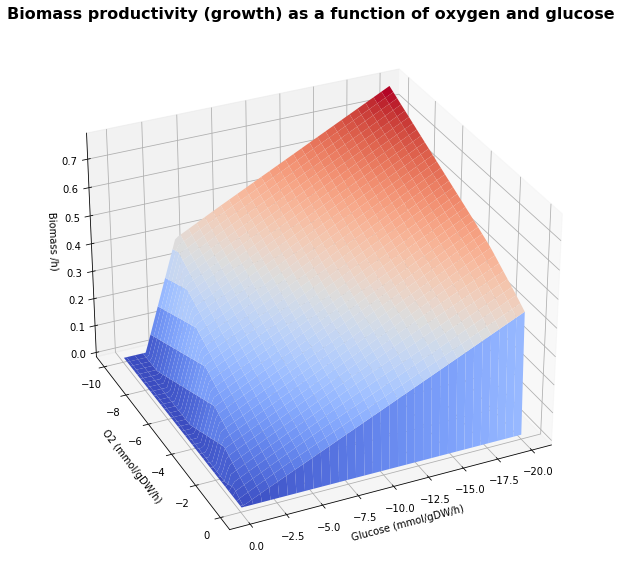

In [64]:
# Biomass productivity as a function of oxygen and glucose
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection="3d")
X, Y = np.meshgrid(glucose_input[:N_POINTS], o2_input[::N_POINTS])
ax.view_init(30,65)
ax.plot_surface(X, Y, np.array(growth_prod).reshape(N_POINTS, N_POINTS), shade=True, cmap=cm.coolwarm)
ax.set_xlabel("Glucose (mmol/gDW/h)")
ax.set_ylabel("O2 (mmol/gDW/h)")
ax.set_zlabel("Biomass /h)")
ax.set_title("Biomass productivity (growth) as a function of oxygen and glucose", {'fontsize': 16, 'fontweight': 'bold'})
plt.show()

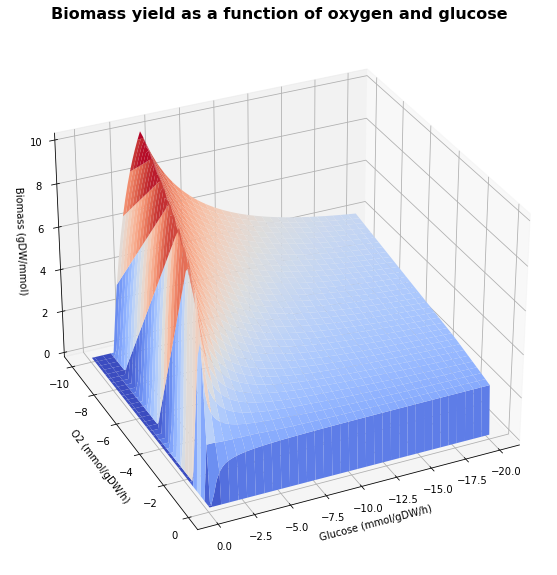

In [66]:
# Biomass yield as a function of oxygen and glucose
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection="3d")
X, Y = np.meshgrid(glucose_input[:N_POINTS], o2_input[::N_POINTS])
ax.view_init(30,65)
ax.plot_surface(X,Y, np.nan_to_num(np.array(growth_yield).reshape(N_POINTS, N_POINTS)), shade=True, cmap=cm.coolwarm)
ax.set_xlabel("Glucose (mmol/gDW/h)")
ax.set_ylabel("O2 (mmol/gDW/h)")
ax.set_zlabel("Biomass (gDW/mmol)")
ax.set_title("Biomass yield as a function of oxygen and glucose", {'fontsize': 16, 'fontweight': 'bold'})
plt.show()

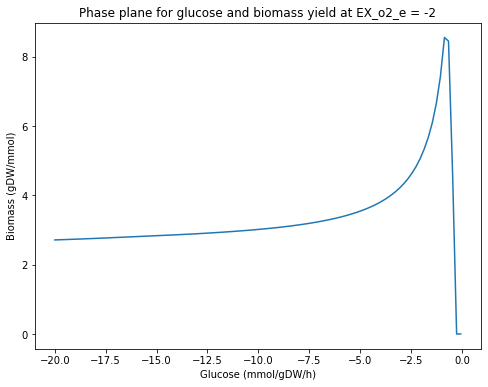

In [79]:
# Phase plane for glucose and progesterone yield at EX_o2_e = -2
set_o2_prod_env = prod_env_growth.loc[prod_env_growth['EX_o2_e'] == -2]

fig = plt.figure(figsize=(8,6))
plt.plot(set_o2_prod_env['EX_glc__D_e'],set_o2_prod_env['carbon_yield_maximum'])
plt.xlabel("Glucose (mmol/gDW/h)")
plt.ylabel("Biomass (gDW/mmol)")
plt.title("Phase plane for glucose and biomass yield at EX_o2_e = -2")
plt.show()

In [80]:
# Value for maximum biomass yield:
set_o2_prod_env.loc[set_o2_prod_env['carbon_yield_maximum']>8.5][['carbon_source','flux_maximum','carbon_yield_maximum','EX_glc__D_e','EX_o2_e']]

carbon_source  flux_maximum  carbon_yield_maximum  EX_glc__D_e  EX_o2_e
8176   EX_glc__D_e       0.06992              8.554287    -0.856471     -2.0